In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [4]:
ventas = pd.read_csv('ventas_detalladas_2025_v3_1.csv', sep=',')
ventas.head()

,Num_Boleta,Fecha,SKU,Descripcion,Categoria,Unidad_medida,Precio_unidad,Cantidad_item,Subtotal_item,Importe_total_boleta
0,B25-000001,2025-01-01,SKU-0909,Ron Santiago Queirolo 200g,Licores,unit,39.0,2,78.0,101.6
1,B25-000001,2025-01-01,SKU-0497,Avena Inca Sur 500g,Abarrotes,unit,11.8,2,23.6,101.6
2,B25-000002,2025-01-01,SKU-0986,Panetón Gloria unidad,Panadería,unit,19.3,1,19.3,40.3
3,B25-000002,2025-01-01,SKU-0741,Gaseosa Coca Cola 1L,Bebidas,unit,12.0,1,12.0,40.3
4,B25-000002,2025-01-01,SKU-0354,Mantequilla Vigor 400g,Lácteos,unit,9.0,1,9.0,40.3


In [5]:
ventas['Fecha'] = pd.to_datetime(ventas['Fecha'])

In [ ]:
# Agrupar ventas diarias por boleta
ventas_diarias = (
    ventas.groupby('Fecha')['Num_Boleta']
    .nunique()   # cuenta cuántas boletas únicas hay ese día
    .reset_index()
    .rename(columns={'Num_Boleta': 'ventas_diarias'})
)

In [15]:
# Calcular la cantidad total vendida por SKU y por día
ventas_diarias = (
    ventas.groupby(['Fecha', 'SKU'])['Cantidad_item']
    .sum()   # total de unidades vendidas del SKU en esa fecha
    .reset_index()
    .rename(columns={'Cantidad_item': 'ventas_diarias'})
)

print(ventas_diarias.head())

       Fecha       SKU  ventas_diarias
0 2025-01-01  SKU-0001               3
1 2025-01-01  SKU-0002              12
2 2025-01-01  SKU-0005               3
3 2025-01-01  SKU-0009               1
4 2025-01-01  SKU-0013               2


In [16]:
ventas_diarias.columns

Index(['Fecha', 'SKU', 'ventas_diarias'], dtype='object')

In [17]:
ventas_diarias.head()

,Fecha,SKU,ventas_diarias
0,2025-01-01,SKU-0001,3
1,2025-01-01,SKU-0002,12
2,2025-01-01,SKU-0005,3
3,2025-01-01,SKU-0009,1
4,2025-01-01,SKU-0013,2


In [18]:
# Escalar datos
scaler = MinMaxScaler()
ventas_diarias['ventas_scaled'] = scaler.fit_transform(ventas_diarias[['ventas_diarias']])

In [24]:
# Crear secuencia
lookback = 30

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(ventas_diarias['ventas_scaled'].values, lookback)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)

In [25]:
# Dividir en entrenamiento (80%) y prueba (20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"✅ Formato de datos - X_train: {X_train.shape}, X_test: {X_test.shape}")

✅ Formato de datos - X_train: (37363, 30, 1), X_test: (9341, 30, 1)


In [26]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])


In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0029 - mae: 0.0367 - val_loss: 0.0033 - val_mae: 0.0367
Epoch 2/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.0029 - mae: 0.0366 - val_loss: 0.0032 - val_mae: 0.0376
Epoch 3/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0028 - mae: 0.0366 - val_loss: 0.0033 - val_mae: 0.0391
Epoch 4/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0028 - mae: 0.0366 - val_loss: 0.0032 - val_mae: 0.0370
Epoch 5/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0028 - mae: 0.0365 - val_loss: 0.0032 - val_mae: 0.0370
Epoch 6/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0028 - mae: 0.0365 - val_loss: 0.0032 - val_mae: 0.0370
Epoch 7/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0028 - mae: 0.0365 - val_loss: 0.0032 - val_mae: 0.0378
Epoch 8/80
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0028 - mae: 0.0365 - val_loss: 0.0032 - val_mae: 0.0365
Epoch 9/80
1168/1168 ━━━

In [29]:
y_pred = model.predict(X_test)

# Desescalar valores
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_real = scaler.inverse_transform(y_pred)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae = mean_absolute_error(y_test_real, y_pred_real)
print(f"📊 RMSE: {rmse:.4f}")
print(f"📉 MAE: {mae:.4f}")

292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
📊 RMSE: 2.0134
📉 MAE: 1.3345


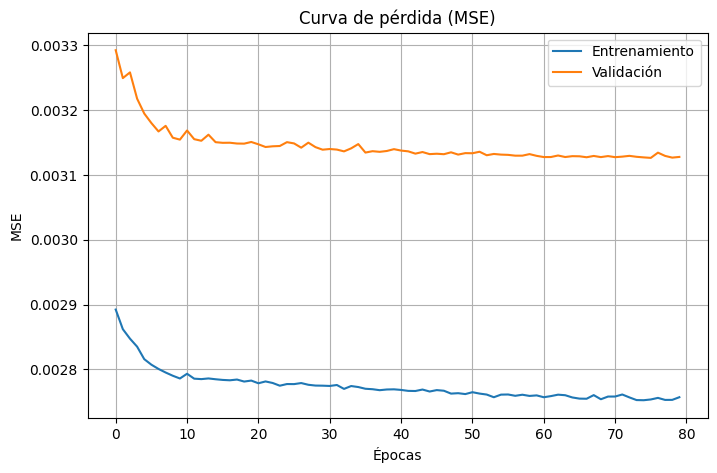

In [30]:
# 🔹 Pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curva de pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

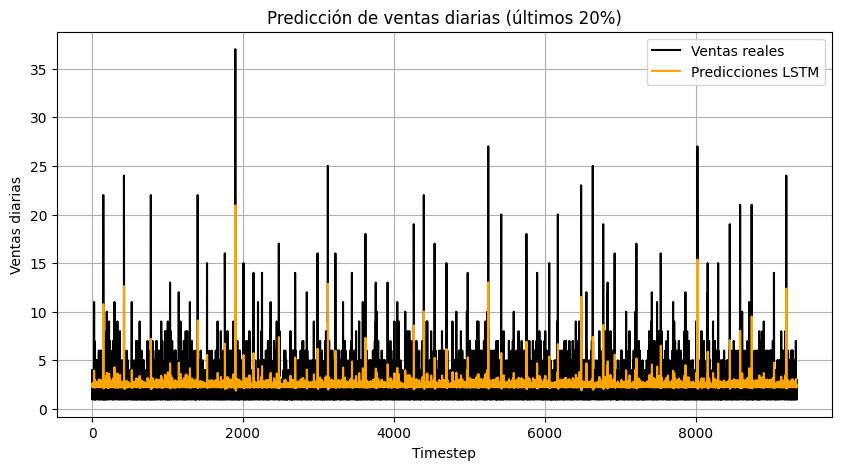

In [31]:

# 🔹 Predicciones vs reales
plt.figure(figsize=(10,5))
plt.plot(y_test_real, label='Ventas reales', color='black')
plt.plot(y_pred_real, label='Predicciones LSTM', color='orange')
plt.title('Predicción de ventas diarias (últimos 20%)')
plt.xlabel('Timestep')
plt.ylabel('Ventas diarias')
plt.legend()
plt.grid(True)
plt.show()